Data can be download from the following link
https://search.earthdata.nasa.gov/portal/ghrc/search?fsm0=Atmospheric%20Electricity&fst0=Atmosphere

* Last modified 7-25-2022

In [1]:
import re
import pandas as pd
from datetime import datetime
from ray.util.multiprocessing import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [2]:
fname = ['NALMA_220718_233000_0600.dat',
'NALMA_220718_234000_0600.dat',
'NALMA_220718_235000_0600.dat']

In [3]:
# read text file
def readFile(fname):
    with open(fname,mode='rt') as f:
        nalma_data = f.read()
    f.close()
    return nalma_data

In [4]:
# get arry info
def get_arry_info(fdata):
    array_data = fdata[0:709].split('\n')
    array_data = array_data[2:]
    arryInfo = pd.DataFrame([text.split(': ') for text in array_data],columns=['Features','Values']).astype('string')
    return arryInfo

In [5]:
# get process information
def get_process_info(fdata):
    expr = '(?<=(?:Sta_info):[\s*])'\
            '([A-Z]?)(\D+)([+-]?\d+[.]?\d+)'\
            '(\s+[+-]\d+[.]\d+)'\
            '(\s+\d+[.]?\d+)'\
            '(\s+\d+[.]?\d+)'\
            '(\s+\d+)(\s+\d+)'
        
    d1 = pd.DataFrame(re.findall(expr,fdata[794:1844]))

    expr = '(?<=(?:Sta_data):[\s*])'\
           '([A-Z]?)(\D+)'\
           '(\d+)(\s+\d+)'\
           '(\s+\d+)'\
           '(\s+\d+)'\
           '(\s+\d+[.]?\d+)'\
           '(\s+\d+[.]?\d+)'\
           '(\s+\w+)'

    d2 = pd.DataFrame(re.findall(expr,fdata[1942:2939]))

    proceInfo = pd.concat([d1,d2.loc[:,2:]],axis=1,join='outer',ignore_index=True)

    new_cols = {0:'id',1:'name',2:'lat(d)',
                3:'lon(d)',4:'alt(m)',5:'delay(ns)',
                6:'board_rev',7:'rec_ch',8:'win(us)',
                9:'dec_win(us)',10:'data_ver',11:'rms_error(ns)',
                12:'sources(%)',13:'<P/P_m>',14:'active'}

    proceInfo = proceInfo.rename(columns=new_cols)

    return proceInfo

In [6]:
# get lightning data

def get_loc_data(fdata):
    expr ='(\d+.\d+)'\
        '(\s+[+-]?\d+[.]?\d+)'\
        '(\s+[+-]?\d+[.]?\d+)'\
        '(\s+[+-]?\d+[.]?\d+)'\
        '(\s+[+-]?\d+[.]?\d+)'\
        '(\s+[+-]?\d+[.]?\d+)'\
        '(\s[0-9a-zA-Z]*)'

    loc_data = pd.DataFrame(re.findall(expr, fdata)).astype('string',copy=False)
    loc_data = loc_data.rename(columns={0:'Time (s)',
                        1:'Latitude',
                        2:'Longitude',
                        3:'Altitude (m)',
                        4:'reduced chi^2',
                        5:'P(dBW)',
                        6:'mask'});
    return loc_data

In [7]:
# combined all the functions

def extract_NALMA(fname):
    fdata = readFile(fname)
    arryInfo = get_arry_info(fdata)
    proceInfo = get_process_info(fdata)
    loc_data = get_loc_data(fdata)

    return arryInfo,proceInfo,loc_data

In [8]:
#parallel processing with "Ray"
pool = Pool()
results = pool.map(extract_NALMA, fname)
pool.close()

In [9]:
# seperate results from the parallel processing into 3 data frame

arryInfo = []
proceInfo = []
locs = []

for data in results:
    proceInfo.append(data[0])
    arryInfo.append(data[1])
    locs.append(data[2])
    
locs = pd.concat(locs, axis=0)
arryInfo = pd.concat(arryInfo, axis=0)
proceInfo = pd.concat(proceInfo, axis=0)

In [10]:
locs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605 entries, 0 to 949
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Time (s)       1605 non-null   string
 1   Latitude       1605 non-null   string
 2   Longitude      1605 non-null   string
 3   Altitude (m)   1605 non-null   string
 4   reduced chi^2  1605 non-null   string
 5   P(dBW)         1605 non-null   string
 6   mask           1605 non-null   string
dtypes: string(7)
memory usage: 100.3 KB


In [11]:
# get coordinate center of the array
Coord_center = [float(val) for val in proceInfo.iloc[5,1].split(' ')]
# convert data in to numarics
locs.iloc[:,0:6] = locs.iloc[:,0:6].astype('float',copy=False)
# filter out Chi-squared <= 5
index = locs.iloc[:,4]<= 5;
# get time differance
dt = locs.iloc[:,0] - locs.iloc[0,0]


In [12]:
idmax = locs.iloc[:,1].idxmax()
idmin = locs.iloc[:,1].idxmin()

left_coner = [locs.iloc[idmin,1],locs.iloc[idmin,2]]
right_coner = [locs.iloc[idmax,1],locs.iloc[idmax,2]]

right_coner

[35.16663646, -86.45357307]

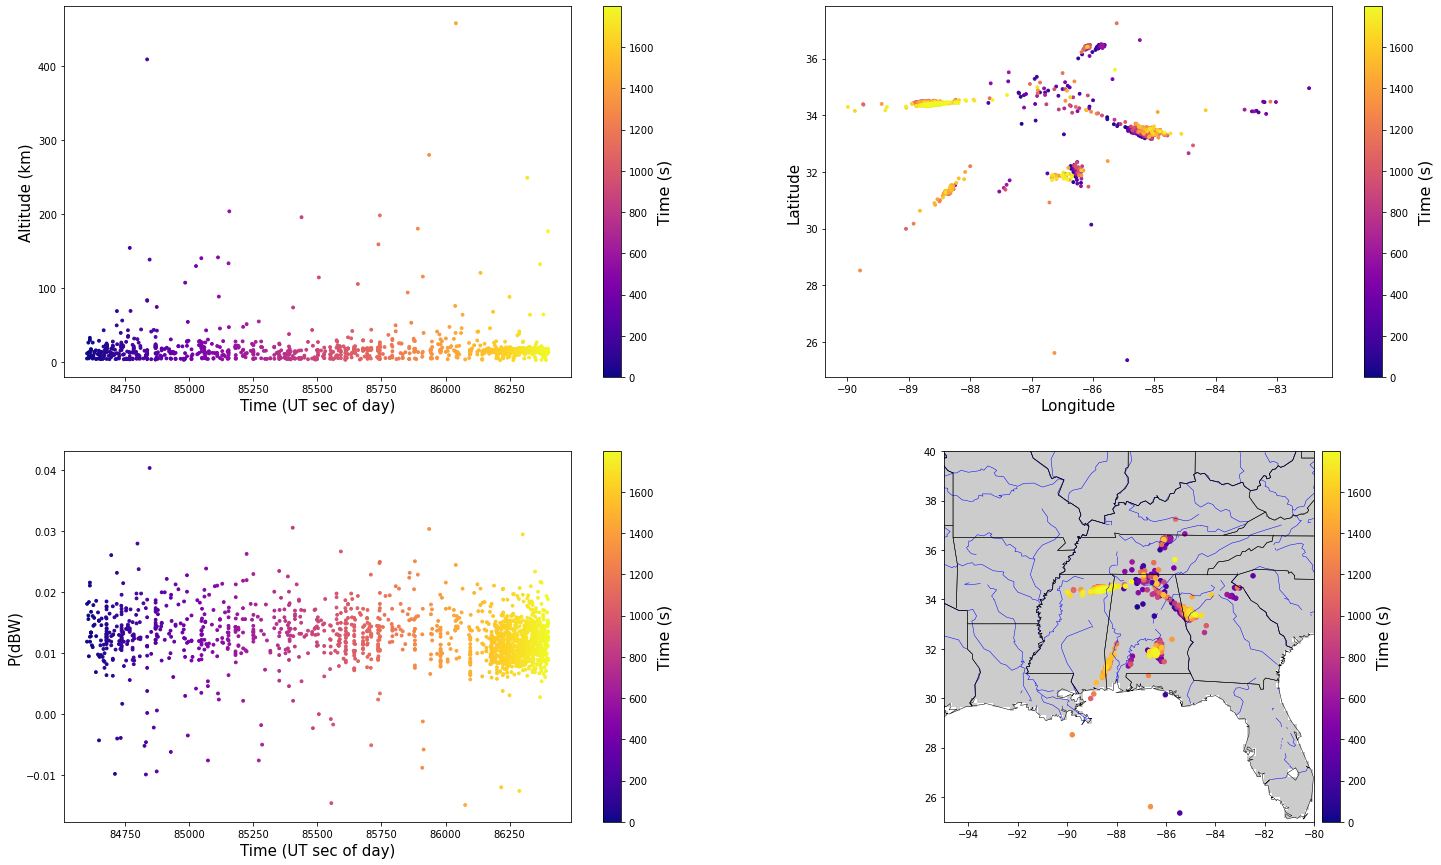

In [18]:
plt.figure(figsize=(25, 15))
ax1 = plt.subplot(2,2,1)
plt.scatter(locs.loc[index,'Time (s)'],locs.loc[index,'Altitude (m)']/1000,s=8,c=dt[index],cmap='plasma');
plt.colorbar().set_label(label = 'Time (s)',size=16);
plt.xlabel('Time (UT sec of day)',fontsize = 15);
plt.ylabel('Altitude (km)',fontsize = 15);



plt.subplot(2,2,2)
plt.scatter(locs.loc[index,'Longitude'],locs.loc[index,'Latitude'],s=8,c=dt[index],cmap='plasma');
plt.colorbar().set_label(label = 'Time (s)',size=16);
plt.ylabel('Latitude',fontsize = 15);
plt.xlabel('Longitude',fontsize = 15);


plt.subplot(2,2,3)
plt.scatter(locs.loc[index,'Time (s)'],locs.loc[index,'P(dBW)']/1000,s=8,c=dt[index],cmap='plasma');
plt.colorbar().set_label(label = 'Time (s)',size=16);
plt.xlabel('Time (UT sec of day)',fontsize = 15);
plt.ylabel('P(dBW)',fontsize = 15);

plt.subplot(2,2,4)
# map = Basemap(lat_0=Coord_center[0],lon_0=Coord_center[1],
# llcrnrlat = 25,llcrnrlon = -130,urcrnrlat = 50,urcrnrlon = -60,
# resolution='l',suppress_ticks=False)

map = Basemap(lat_0=Coord_center[0],lon_0=Coord_center[1],
llcrnrlat = 25,llcrnrlon = -95,urcrnrlat = 40,urcrnrlon = -80,
resolution='l',suppress_ticks=False,fix_aspect=True)

map.drawcoastlines(linewidth=0.5)
map.drawcountries(linewidth=0.2)
# map.drawcounties()
map.drawlsmask()
map.drawrivers(color='b',linewidth=0.5)
map.drawstates(color='k',linewidth=0.5)
map.scatter(locs.loc[index,'Longitude'],locs.loc[index,'Latitude'],latlon=True,s=20,c=dt[index],cmap='plasma')
map.colorbar().set_label(label = 'Time (s)',size=16);
